This python script uses an elastic net regression to model the data for the interaction of two signals in an optical fiber. The target variable is the energy E. 

## Elastic Net regression (L1+L2)

Linear regression with combined L1 and L2 regularization.
Minimizes the cost function:

(0.5/N) * |y - Xw|^2 + alpha * L1_ratio * |w| + 0.5 * alpha * (1 - L1_ratio)*|w|^2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
import pickle # to save the model

## Load the dataset

In [2]:
df = pd.read_csv('Data-Energy.dat')

## Explore the dataset

In [3]:
df.head()

,B2,G,DO,Dz,P1,P2,E
0,0.0050,0.002,5,0.5,100,10,0.794660
1,0.0075,0.002,5,0.5,100,10,1.306685
2,0.0100,0.002,5,0.5,100,10,1.565490
3,0.0150,0.002,5,0.5,100,10,1.743379
4,0.0200,0.002,5,0.5,100,10,1.789472


In [4]:
df.describe()

,B2,G,DO,Dz,P1,P2,E
count,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000
mean,0.019360,0.001965,5.209302,0.467442,91.627907,15.232558,1.557556
std,0.003822,0.000334,0.832613,0.110671,20.345847,13.970781,1.017889
min,0.005000,0.000500,4.000000,0.000000,20.000000,5.000000,0.000000
25%,0.020000,0.002000,5.000000,0.500000,100.000000,10.000000,0.780392
50%,0.020000,0.002000,5.000000,0.500000,100.000000,10.000000,1.460797
75%,0.020000,0.002000,5.000000,0.500000,100.000000,10.000000,2.116922
max,0.030000,0.003000,9.000000,0.600000,100.000000,70.000000,4.323701


In [5]:
df = df.sample(frac=1) # to shuffle the dataset

## Correlation with target variable

In [6]:
df.corr()['E'].abs().sort_values(ascending=False)

E     1.000000
P2    0.787279
P1    0.462497
Dz    0.358922
G     0.289597
DO    0.185260
B2    0.101498
Name: E, dtype: float64

## Select the features

In [7]:
cols = df.columns.values
cols

array(['B2', 'G', 'DO', 'Dz', 'P1', 'P2', 'E'], dtype=object)

In [8]:
x = df[cols[0:6]] # B2, G, DO, Dz, P1, P2
y = df[cols[6]] # E

## Split into train and test sets

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1)

## Scale the features

In [10]:
#Standardize features by removing the mean and scaling to unit variance. 
#Always do it when using stochastic gradient descent.
x_scaler = StandardScaler()
x_train = x_scaler.fit_transform(x_train)
x_test = x_scaler.transform(x_test)

## Hyperparameter optimization with cross-validation

In [11]:
estimator = ElasticNet()

parameters = {'alpha': (0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000), 'l1_ratio':(0.1,0.2,0.4,0.5,0.6,0.7,0.8,0.9,1.0)}

grid_search = GridSearchCV(estimator, parameters, cv =5, scoring='r2', n_jobs=-1)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'alpha': (0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000), 'l1_ratio': (0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=0)

In [12]:
grid_search.best_score_

0.94464709507288225

In [13]:
 grid_search.best_params_

{'alpha': 0.01, 'l1_ratio': 0.1}

## Evaluate the best model

In [14]:
model = grid_search.best_estimator_
#model.fit(x_train, y_train)

In [15]:
model.score(x_test,y_test)

0.97899791622774246

## Model parameters

In [16]:
model.intercept_

1.5126121899965326

In [17]:
model.coef_

array([ 0.1444034 ,  0.34763942, -0.19136256,  0.41103123,  0.41522854,
        0.58794174])

## Make predictions using the best model

In [18]:
y_pred = model.predict(x_test)

## Compare data with prediction

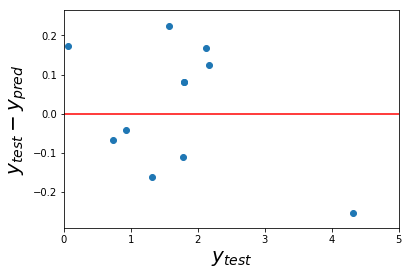

In [19]:
plt.scatter(y_test, (y_test - y_pred))
plt.plot([0,5],[0,0],c='r')
plt.xlim([0,5])
plt.xlabel('$y_{test}$',fontsize=20)
plt.ylabel('$y_{test}-y_{pred}$',fontsize=20)
plt.show()

## Save and load the model

In [20]:
pickle.dump(model, open('model.sav','w'))

In [21]:
loaded_model = pickle.load(open('model.sav', 'r'))

In [22]:
loaded_model.predict(x_test)

array([ 0.97349973,  0.79693411,  1.70951054, -0.11564232,  1.70951054,
        1.95484748,  2.04522544,  1.89394159,  4.57586322,  1.47064782,
        1.34064844])

In [23]:
loaded_model.score(x_test,y_test)

0.97899791622774246